In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Импорты

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
from keras import layers
from keras.layers import Dense, Dropout, GlobalMaxPooling2D, Flatten
from keras.preprocessing.image import load_img
from keras.applications import VGG16
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


Работа с папками

In [ ]:
print(len(os.listdir("/content/gdrive/My Drive/animalsval")))

# テストデータ10件をリストします。
'''
print(os.listdir("../input/test1/test1")[:10])
'''

96


'\nprint(os.listdir("../input/test1/test1")[:10])\n'

In [4]:

CDnames_train = os.listdir("/content/gdrive/My Drive/animals")
CDnames_val = os.listdir("/content/gdrive/My Drive/animalsval/")
def table_of_class(CDnames):
  categories = []
  # CDnames - лист с изображениями [0]-из папки с кошками [1] - c собаками.
  for i in CDnames:
           whichCategorys = "0" if i[0]=="c" else "1"
           categories.append(whichCategorys)
  # Создание таблицы(строка:имя файла - категория(0 или 1))  .       
  df = pd.DataFrame({
    'filename': CDnames,
    'category': categories
})
  return df
train_df=table_of_class(CDnames_train)  
val_df=table_of_class(CDnames_val) 
val_df.head(40)

,filename,category
0,dog.10024.jpg,1
1,dog.10017.jpg,1
2,dog.10019.jpg,1
3,dog.10022.jpg,1
4,dog.10016.jpg,1
5,dog.10023.jpg,1
6,dog.100.jpg,1
7,dog.10018.jpg,1
8,dog.1002.jpg,1
9,dog.10020.jpg,1


In [5]:


val_df['category'].value_counts()
train_df['category'].value_counts()


1    2002
0    2001
Name: category, dtype: int64

Перекидывание в одну папку

In [ ]:
import shutil
def replace(CDnames,s,path="/content/folder/"):
  s0=s
  for i,j in enumerate(CDnames):
      for filename in j:
        if i==0:
          s+='cats/'
        else:
           s+='dogs/' 
        shutil.move( s+filename, path+"new"+filename )  
        s=s0 
replace(CDnames_train,"/content/gdrive/My Drive/animals/")
'''
replace(CDnames_val,"/content/gdrive/My Drive/animalsval/")  
'''         

'\nreplace(CDnames_val,"/content/gdrive/My Drive/animalsval/")  \n'

Модель

In [7]:
image_size = 224
input_shape = (image_size, image_size, 3)


epochs = 20
batch_size = 16

Fine-Tunned model

In [ ]:
# The output layer of the VGG 16 is 1,000 classes, and this time the output 
# layer is replaced for 2-class classification. 
# VGG16モデルのダウンロード(事前にKernelからInternet接続ができるよう設定しておきます)
# VGG16は1,000クラスの出力層となっており、今回は犬、猫の２クラス分類となるため出力層の取り替えを行います。
# このためinclude_top=Falseとし、出力層の前の層を利用します。
VGG16model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

58892288/58889256 [==============================] - 5s 0us/step


In [ ]:
VGG16model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Заморозка слоев (первых 15)

In [ ]:
# Freeze the layer just before the last convolutional layer.
for layer in VGG16model.layers[:15]:
    layer.trainable = False

In [ ]:
for layer in VGG16model.layers[:-1]:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True


In [ ]:
# Set the 5th block of the VGG16 model as the last output layer.
# VGG16モデルの5ブロック目を最後の出力層とする。
last_layer = VGG16model.get_layer('block5_pool')
last_output = last_layer.output

Создание нового вывода с кросс-энтропилос классификацией(2)

In [ ]:
# Create a new output layer for 2 class classification.
# 分類は犬猫の２クラスの分類を出力する層を新規に作成する。
# プーリング層を置き、入力はVGG16の出力を受け取るようにする。
new_last_layers = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
# 512ノードの全結合層を追加、活性化関数はReLU
new_last_layers = Dense(512, activation='relu')(new_last_layers)
# Add a dropout rate of 0.5
# ドロップアウトを追加、レートは0.5
new_last_layers = Dropout(0.5)(new_last_layers)
# Add a final sigmoid layer for classification
# 最後に犬猫のクラスを示すノード２つの出力層を作り、シグモイド関数を適用する
new_last_layers = layers.Dense(2, activation='sigmoid')(new_last_layers)

In [8]:
# Combine the VGG 16 with the output layer.
# VGG16と出力層を結合する。
import keras.backend as K
import tensorflow as tf
def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
'''    

model = Model(VGG16model.input, new_last_layers)
# complile.
# モデルのコンパイル。
model.compile(loss = "binary_crossentropy",
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=[get_f1])
# Display model summary.
# サマリ表示
model.summary()
'''

'    \n\nmodel = Model(VGG16model.input, new_last_layers)\n# complile.\n# モデルのコンパイル。\nmodel.compile(loss = "binary_crossentropy",\n              optimizer=SGD(lr=1e-4, momentum=0.9),\n              metrics=[get_f1])\n# Display model summary.\n# サマリ表示\nmodel.summary()\n'

In [ ]:
train_df.sample(frac=1).reset_index()
val_df.sample(frac=1).reset_index()

,index,filename,category
0,5,cat.10004.jpg,0
1,56,dog.10018.jpg,1
2,94,dog.10728.jpg,1
3,41,cat.10033.jpg,0
4,46,cat.1008.jpg,0
...,...,...,...
91,91,dog.1046.jpg,1
92,61,dog.10338.jpg,1
93,55,dog.10023.jpg,1
94,85,dog.10408.jpg,1


In [9]:
train_datagen = ImageDataGenerator(
    
    rotation_range=15,
    
    rescale=1./255,
    
    shear_range=0.2,
  
    zoom_range=0.2,
    
    horizontal_flip=True,
    
    fill_mode='nearest',
    
    width_shift_range=0.1,
    
    height_shift_range=0.1
)
# Generate a batch of expanded data from data frames and directory.

train_generator = train_datagen.flow_from_dataframe(
   
    train_df, 
    
    "/content/gdrive/My Drive/animals",
   
    x_col='filename',
   
    y_col='category',
   
    class_mode='categorical',
    
    target_size=(image_size, image_size),
   
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    val_df, 
    "/content/gdrive/My Drive/animalsval", 
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(image_size, image_size),
    batch_size=batch_size
)


Found 4002 validated image filenames belonging to 2 classes.
Found 96 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1 validated image filenames belonging to 1 classes.


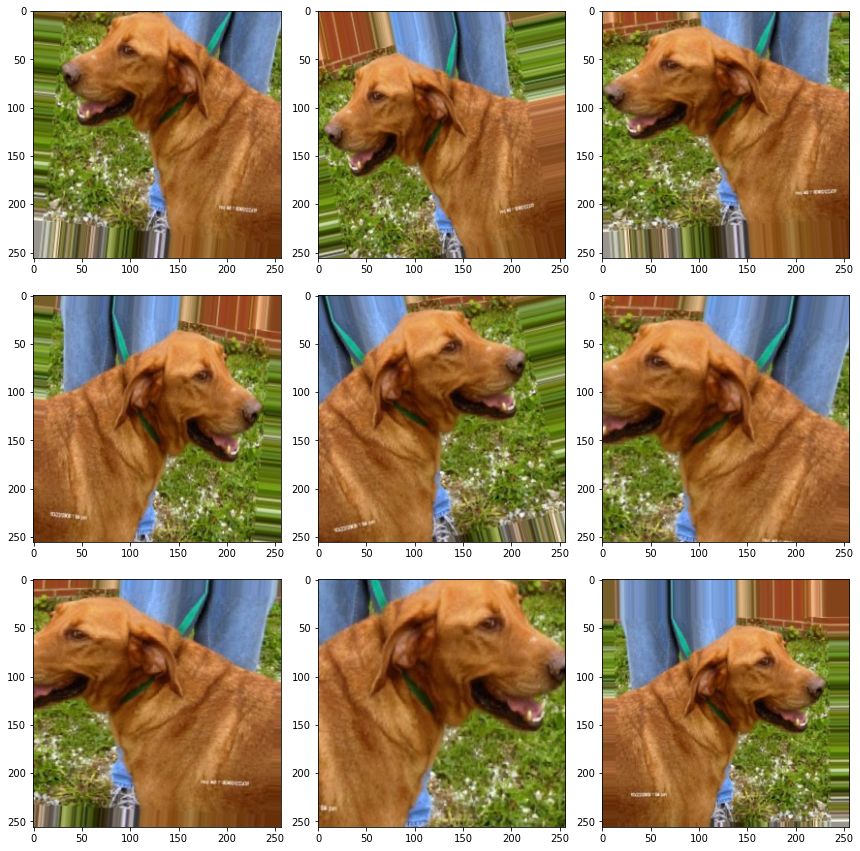

'\nfor X_batch, Y_batch in example_generator:\n        image = X_batch\n        print(image)\n'

In [10]:
# 拡張画像のサンプル表示を行うジェネレータを準備
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/gdrive/My Drive/animals", 
    x_col='filename',
    y_col='category',
    
)
# Display a sample of expanded image data
# 拡張した画像データのサンプルを表示する

plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()
'''
for X_batch, Y_batch in example_generator:
        image = X_batch
        print(image)
'''

In [13]:
total_train = train_df.shape[0]
total_validate = val_df.shape[0]

In [ ]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]
_get_available_gpus()    

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


['/device:GPU:0']

In [ ]:
from keras.utils import multi_gpu_model
parallel_model = multi_gpu_model(model, gpus=1)

AttributeError: ignored

In [14]:
import time
start = time.time()

# Fit Model
# fine-tune the model
# トレーニングの実施
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

# Display of learning time
# トレーニング時間の表示
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

Epoch 1/20
250/250 [==============================] - 2608s 10s/step - loss: 0.0443 - get_f1: 0.9835 - val_loss: 0.0152 - val_get_f1: 0.9792
Epoch 2/20
250/250 [==============================] - 2584s 10s/step - loss: 0.0410 - get_f1: 0.9848 - val_loss: 0.0133 - val_get_f1: 0.9688
Epoch 3/20


KeyboardInterrupt: ignored

In [ ]:
# evaluation
# モデルの評価
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.994872  ;  loss = 0.034737 


Графики

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


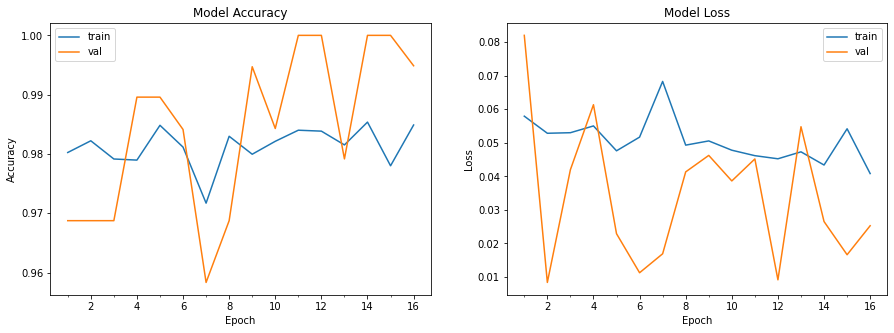

In [ ]:
# loss and accuracy graph
# 損失関数の値と分類精度のグラフ
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
plot_model_history(history,"get_f1","val_get_f1")    

Сохранение

In [ ]:
from keras.models import load_model
model.save("my_model4.h5") 

In [11]:
from keras.models import load_model
dependencies = {
    'get_f1': get_f1
}


model = load_model("/content/gdrive/My Drive/my_model3.h5",custom_objects=dependencies)

In [ ]:
predictions = model.predict(ex_generator[0][0])
res=predictions[0]
e=2.718281828
print(e**res[0]/(e**res[0]+e**res[1]))

0.3002944125531441


Работа с функциями обработки для конкурса

In [ ]:
def table_of_class(CDnames):
  categories = []
  # CDnames - лист с изображениями [0]-из папки с кошками [1] - c собаками.
  for i in CDnames:
           whichCategorys = "0" if i[0]=="c" else "1"
           categories.append(whichCategorys)
  # Создание таблицы(строка:имя файла - категория(0 или 1))  .       
  df = pd.DataFrame({
    'filename': CDnames,
    'category': categories
})
  return df
CDnames=os.listdir("/content/gdrive/My Drive/EXX" )
ex_df=table_of_class(CDnames)
ex_df.head(1)

,filename,category
0,Screenshot_3.png,1


In [ ]:
ex_datagen = ImageDataGenerator(rescale=1./255)
# Generate a batch of expanded data from data frames and directory.

ex_generator = ex_datagen.flow_from_dataframe(
   
    ex_df, 
    
    "/content/gdrive/My Drive/EXX" ,
   
    x_col='filename',
   
    y_col='category',
   
    class_mode='categorical',
    
    target_size=(image_size, image_size),
   
    batch_size=batch_size
)

Found 1 validated image filenames belonging to 1 classes.


In [ ]:
for X_batch, Y_batch in ex_generator:
        print(X_batch[0][0][0][0])

0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118
0.9294118


KeyboardInterrupt: ignored

Eval.py

In [ ]:
from keras.models import load_model
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from PIL import Image
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def standardize_input(image):
        """Приведение изображений к стандартному виду. 
        Входные данные: изображение
        Выходные данные: стандартизированное изображений.
        """
        
        img = Image.open(image).convert('RGB')
        img = img.resize((224,224), Image.ANTIALIAS)
        standard_im = np.array(img.getdata()).reshape(1,img.size[0], img.size[1], 3)/255
        ## TODO: Если вы хотите преобразовать изображение в формат, одинаковый для всех изображений, сделайте это здесь.
        return standard_im

# Пропишите путь к вашей модели
MODEL_FILE_NAME = '/content/gdrive/My Drive/my_model3.h5'

def load_final_model():
    """ Функция осуществляет загрузку модели нейронной сети из файла MODEL_FILE_NAME.
        Выходные параметры: загруженная модель
    """
    
    dependencies = {
    'get_f1': get_f1
}
    model = load_model(MODEL_FILE_NAME,custom_objects=dependencies)
    ## TODO: Функция загрузки модели
    return model

def predict(image, model):
    """ Функция осуществляет подачу данных на вход нейронки и возвращает метку класса в виде метки 0(кошка) или 1(собака)
         Входные параметры: изображение
         Выходные параметры: метка класса
    """
    predictions = model.predict(image[0])
    res=predictions[0]
    e=2.718281828
    label=0 if e**res[0]/(e**res[0]+e**res[1])>0.5  else 1
    ## TODO: Функция предсказания метки по заданной картинке

    return label

Main.py

In [ ]:
# -*- coding: utf-8 -*-
import cv2  # computer vision library
import os

from sklearn.metrics import f1_score
import numpy as np
from imutils import paths
#from eval import standardize_input, predict, load_final_model


def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


# Image data directories
def one_hot_encode(label):
    dictAnimal = {'cats': 0, 'dogs': 1}
    """ Функция осуществляет перекодировку картинки, поступающей на вход,
     в массив элементов, соответствующий выходному сигналу

     Входные параметры: текстовая метка
     Выходные параметры: метка ввиде массива

     Пример:

        one_hot_encode("cats") должно возвращать: 0
        one_hot_encode("dogs") должно возвращать: 1

     """
    return dictAnimal[label]


def load_data():
    IMAGE_DIR_VALIDATION = "/content/gdrive/My Drive/датасет_тест2"
    imagePaths = sorted(list(paths.list_images(IMAGE_DIR_VALIDATION)))
#     TRAINING_IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TRAINING)
#     VALIDATION_IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_VALIDATION)

    data = []
    labels = []
    for imagePath in imagePaths:
        data.append(standardize_input(imagePath))
        label = imagePath.split(os.path.sep)[-2]
        
        labels.append(one_hot_encode(label))

    data = np.array(data, dtype="float")
    labels = np.array(labels)

    data, labels = unison_shuffled_copies(data, labels)

    return data, labels


def get_predictions(data, model):
    
    predictions = [predict(np.array([image]), model) for image in data]

    return predictions


def main():
    # MODEL_NAME = 'output/simple_nn.h5'

    data, labels = load_data()
    try:
        model = load_final_model()
    except:
        print('Модель не подгружена, используем константный классификатор')
        model = None
    predictions = get_predictions(data, model)
    try:
        f1 = f1_score(labels, predictions)
        print('F1-мера классификатора:', f1)
    except Exception as e:
        print('Ошибка:', e)

    file = open("score.txt", "w")
    file.write(str(f1))
    file.close()


if __name__ == '__main__':
    main()


F1-мера классификатора: 1.0


In [ ]:
from PIL import Image
img = Image.open("/content/gdrive/My Drive/датасет_тест2/dogs/Собакен.jpg").convert('RGB')
img = img.resize((224,224), Image.ANTIALIAS)
pix = np.array(img.getdata()).reshape(1,img.size[0], img.size[1], 3)/255
predictions = model.predict(pix)
res=predictions[0]
e=2.718281828
print(e**res[0]/(e**res[0]+e**res[1]))

0.268960202034565
